<a href="https://colab.research.google.com/github/lcpbrandao/Basic_ML_training/blob/master/ML_BostonHousePrices_Laislla_(Linear_Reg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import os

%env SPARK_HOME=/opt/spark-2.4.3

exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())
sqlContext = SQLContext(sc)

In [ ]:
df = spark.read.csv("boston.csv", header = True, inferSchema = True )

In [ ]:
df.show(5)

+-------+----+------+----+-----+-----+----+------+---+---+-------+-----+----+
|   CRIM| ZN |INDUS |CHAS|  NOX|   RM| AGE|   DIS|RAD|TAX|PTRATIO|LSTAT|MEDV|
+-------+----+------+----+-----+-----+----+------+---+---+-------+-----+----+
|0.00632|18.0|  2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 4.98|24.0|
|0.02731| 0.0|  7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 9.14|21.6|
|0.02729| 0.0|  7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8| 4.03|34.7|
|0.03237| 0.0|  2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7| 2.94|33.4|
|0.06905| 0.0|  2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 5.33|36.2|
+-------+----+------+----+-----+-----+----+------+---+---+-------+-----+----+
only showing top 5 rows



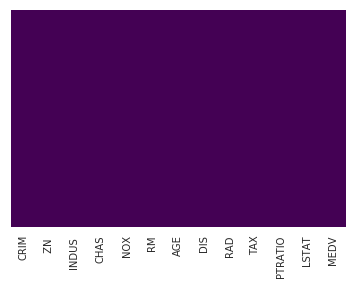

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

boston = df.toPandas()

#HEATMAP PARA VER OS VALORES NULOS NAS COLUNAS
sns.heatmap(boston.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Text(0,0.5,'MEDV')

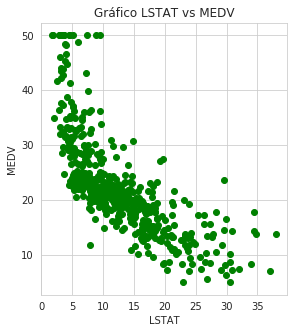

In [ ]:
#GRÁFICO SCATTERPLOT ENTRE A FEATURE E O LABEL

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.scatter(boston.LSTAT, boston.MEDV, color = 'g')
plt.title('Gráfico LSTAT vs MEDV')
plt.xlabel('LSTAT')
plt.ylabel('MEDV')

In [ ]:
#TRANSFORMAR FEATURES EM VETOR PARA PODER COLOCAR NO MODELO

from pyspark.ml.feature import VectorAssembler

vAssembler = VectorAssembler(inputCols = ['LSTAT'], outputCol = 'features')
df2 = vAssembler.transform(df) # Adiciona uma nova coluna a df
df2 = df2.select(['features', 'MEDV']) # Seleciona apenas a nova coluna e a saída


In [ ]:
#SEPARAR BASE DE TREINAMENTO E TESTE

from pyspark.sql import DataFrame
splits = df2.randomSplit([0.7, 0.3]) # Divide os dados em dois conjuntos randômicos
train = splits[0] # com 70% dos dados
test = splits[1] # e os 30% restantes

train.show(3)
test.show(3)

+--------+----+
|features|MEDV|
+--------+----+
|  [1.92]|50.0|
|  [2.47]|41.7|
|  [2.88]|50.0|
+--------+----+
only showing top 3 rows

+--------+----+
|features|MEDV|
+--------+----+
|  [1.73]|50.0|
|  [1.98]|34.9|
|  [2.87]|36.4|
+--------+----+
only showing top 3 rows



In [ ]:
#MODELO REGRASSÃO LINEAR

from pyspark.ml.regression import LinearRegression

# Cria o modelo
lreg = LinearRegression(featuresCol= 'features', labelCol= 'MEDV', maxIter = 30, regParam = 0.3, elasticNetParam = 0.8)

# Treina o modelo com a base de treinamento (data frame formatado)
lrModel = lreg.fit(train)

# Aplica o modelo treinado para predizer a saída (label) na base de testes
predictions = lrModel.transform(test)

In [ ]:
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)



RMSE: 6.034773
r2: 0.551540


In [ ]:
train.describe().show()

+-------+-----------------+
|summary|             MEDV|
+-------+-----------------+
|  count|              357|
|   mean|22.79887955182073|
| stddev|9.024184041644654|
|    min|              5.0|
|    max|             50.0|
+-------+-----------------+

